## Machine Learning Applied to identify protein degradation stability

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

# #import peptides
# #from Bio import SeqIO
import scipy
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
meta_data = pd.read_csv('/stor/work/Wilke/luiz/tail_stability/data/tail_stability_metadata.csv')
meta_data

,ID,sequence,stability
0,mut_1,AAADFTAKVWDAVLGDELMTLAHKYIVKTVYFMQDNR,0.0
1,mut_2,AAEPAAEAPVGVSQLQRNLHQLSLLQPSLLPQNLTLAN,0.0
2,mut_3,AAGEEVAIKLDVSKPKPQLHIESKIYKMMQGGVGIR,0.0
3,mut_4,AAGSCSVSCGRGLMELRFLCMDSALRVPVQEELCGLR,0.0
4,mut_5,AAGSSFALPQKRPHPRWLWEGSLPSRTPLRAMGTLRR,0.0
...,...,...,...
138361,mut_138362,YEETTQELDAQQARLSAKTSEQTGEPAEDTSGVIKMR,13.0
138362,mut_138363,YFYVNEQSGESQWEFPDGEEEEEESQA,13.0
138363,mut_138364,YGRGPQCSSPPAQGAEMEDADSQGAGAPGRPVRQDMR,13.0
138364,mut_138365,YLTRDERKDRDPRVQDFIPNA,13.0


In [3]:
meta_data['length'] = [len(seq) for seq in meta_data['sequence']]
meta_data

,ID,sequence,stability,length
0,mut_1,AAADFTAKVWDAVLGDELMTLAHKYIVKTVYFMQDNR,0.0,37
1,mut_2,AAEPAAEAPVGVSQLQRNLHQLSLLQPSLLPQNLTLAN,0.0,38
2,mut_3,AAGEEVAIKLDVSKPKPQLHIESKIYKMMQGGVGIR,0.0,36
3,mut_4,AAGSCSVSCGRGLMELRFLCMDSALRVPVQEELCGLR,0.0,37
4,mut_5,AAGSSFALPQKRPHPRWLWEGSLPSRTPLRAMGTLRR,0.0,37
...,...,...,...,...
138361,mut_138362,YEETTQELDAQQARLSAKTSEQTGEPAEDTSGVIKMR,13.0,37
138362,mut_138363,YFYVNEQSGESQWEFPDGEEEEEESQA,13.0,27
138363,mut_138364,YGRGPQCSSPPAQGAEMEDADSQGAGAPGRPVRQDMR,13.0,37
138364,mut_138365,YLTRDERKDRDPRVQDFIPNA,13.0,21


<Axes: xlabel='length', ylabel='Count'>

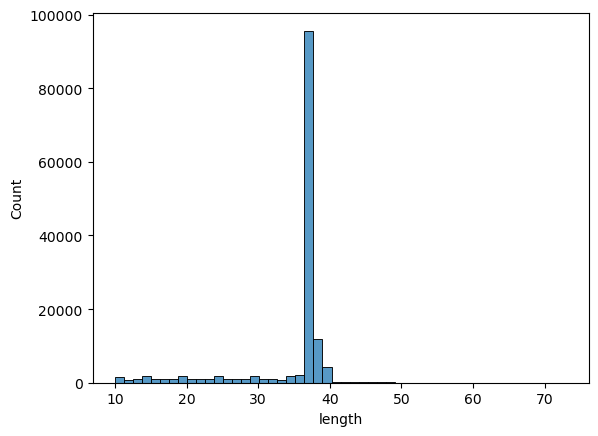

In [4]:
sns.histplot(meta_data['length'], bins=50)

In [5]:
meta_data['length'].describe()

count    138366.000000
mean         34.725836
std           6.405278
min          10.000000
25%          37.000000
50%          37.000000
75%          37.000000
max          73.000000
Name: length, dtype: float64

In [6]:
meta_data.query('length ==40')

,ID,sequence,stability,length
15,mut_16,ADCLRRVQTERPQPQTLQLDFLMKILPNYHHLKKTMRIAN,0.0,40
93,mut_94,AQLLAATCLSKLVSRVSPLPVEQRMDIRNYILTYVARIAR,0.0,40
97,mut_98,ARKKIFQEPKSAHQVEQVLLAYSRCIQACGQERGQGALTD,0.0,40
109,mut_110,ASSPRVLLTVLARHAHDVARAQLGEDAHLYPTLGPGRIAN,0.0,40
300,mut_301,EETSEKKSRKVVIREKAERLSLRKTLEETETYHAKLRIAN,0.0,40
...,...,...,...,...
138065,mut_138066,PGQRPAPVRGLVRPDQPRGGPPPGRLASHGADKPPTPLTD,13.0,40
138116,mut_138117,QDNLEIDEIEDENIKEGPSDSEDIVFEETDTDLQELALTD,13.0,40
138123,mut_138124,QELGSPEERLQDSSDPDTGSEEEGSSRLSPPHSPRDPLTD,13.0,40
138286,mut_138287,STPRAQGAPSPSAHMNLSALAEGQTVLKPEGGEARAALTD,13.0,40


In [7]:
meta_data['length'].between(35, 40).sum()

114456

## Functions

In [8]:
def load_mean_embeds(dir_path):
    '''Iterate over the layers and fit and predict using grid search'''
     # list of all files containing the embeddings and created a dictionary
    embeddings = {}
    #for file in os.listdir(dir_path):
    for file in os.listdir(dir_path)[:500]:
        if file.endswith('.pt'):
            file_path = os.path.join(dir_path, file)
            label = file.split('.pt')[0]
            embeddings[label] = np.array(torch.load(file_path)['mean_representations'])

    # convert to array type sequences_embeddings to a data frame
    df=pd.DataFrame.from_dict(embeddings, orient='index').reset_index()
    df.rename(columns={'index':'ID'}, inplace=True)
    return df

In [9]:
# Split the data into training and testing sets
def split_data(features, target):
    '''Split the data into training and testing sets'''
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


In [10]:
def scale_data(X_train, X_test):
    '''Scale the data'''
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [11]:
def dimention_reduction(X_train_scaled, X_test_scaled, n_components=100):
    '''Perform dimention reduction using PCA'''
    pca = PCA(n_components, random_state=42)
    # Apply PCA only on the training set
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    return X_train_pca, X_test_pca

In [26]:
def fit_regression_model(X_train_pca, y_train, model='linear'):
    '''Fit the regression model'''

    # Create a list of models to test
    if model == 'linear':
        model = LinearRegression()
        param_grid = {'fit_intercept': [True, False]}
    elif model == 'lasso':
        model = Lasso()
        param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1],'max_iter': [100000]}
    elif model == 'svr':
        model = SVR()
        param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 0.1, 0.01, 0.001]}
    else:
        print('Model not found')
        print('Model options: linear, lasso, svr')
    
    # search best hyperparameter 
    grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=10, n_jobs=10)
    
    # train in the whole training set
    model_grid = grid_search.fit(X_train_pca, y_train)
    best_params = model_grid.best_params_
    return model_grid, best_params

In [13]:
def make_predictions(model, X):
    '''Make predictions'''
    pred = model.predict(X)
    return pred

In [14]:
def compute_metrics(test, pred):
    '''Compute metrics'''
    # compute metrics
    r2 = metrics.r2_score(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = metrics.mean_squared_error(test, pred)

    r2 = metrics.r2_score(test, pred)
    mae = metrics.mean_absolute_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    spearman_Coef = scipy.stats.spearmanr(test, pred)

    return {'R2':r2, 'MAE': mae, 'RMSE' : rmse, 'SpearmanCoef': spearman_Coef[0], 'SpearmanPvalue': spearman_Coef[1]}

In [15]:
def plot_results(train_pred, y_train, y_pred, y_test, model_name, filename, model):
    # Plot the results
    filename = f"{filename}.png"
    plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
    plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
    plt.title(f"Model: {model_name}")
    plt.xlabel("Predicted Stability")
    plt.ylabel("True Stability")
    
    global_min = np.floor(min(min(train_pred), min(y_train), min(y_test), min(y_pred)))
    global_max = np.ceil(max(max(train_pred), max(y_train), max(y_test), max(y_pred)))
   
    plt.plot([global_min, global_max], [global_min, global_max], c='k', zorder=0) 
    plt.text(global_min, global_max-4, f'Train R$^2$: {model.score(X_train_scaled, y_train).round(2)}', fontsize = 9)
    plt.text(global_min, global_max-5, f'Test R$^2$: {model.score(X_test_scaled, y_test).round(2)}', fontsize = 9)
    
    plt.legend()
    #plt.savefig(filename, format='png', dpi=300)
    plt.show()
    plt.close()  

## Loading Embeddings

In [16]:
df = load_mean_embeds('/stor/work/Wilke/luiz/tail_stability/embeddings/esm2_15B_embeds_per_layer/10/')
df

,ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,mut_71178,-0.047086,0.040246,-0.182630,-0.197608,-0.109369,-0.066697,-0.028830,0.267403,-0.029425,0.037151,-0.342599,-0.235963,0.054765,-0.036296,-0.077814,0.103564,-0.039441,0.253120,-0.004089,-0.225653,-0.570578,-0.002159,-0.043137,0.157150,0.284280,-0.240852,-0.214000,0.175872,0.222432,0.038861,0.021057,-0.063184,-0.254226,-0.033800,-0.102369,-0.180127,-0.081002,-0.136560,0.064250,0.058175,0.074366,0.258964,0.137874,-0.156145,-0.181923,0.077981,0.107560,0.056881,-0.019066,...,0.262623,-0.131965,-0.153745,-0.167720,0.014037,0.115438,0.027943,0.108064,-0.118115,0.148773,0.144301,0.126186,-0.127451,0.011164,0.215973,0.285998,-0.221551,0.509848,0.427645,-0.067944,0.016490,-0.260869,0.022292,0.060848,-0.028228,-0.269922,-0.020190,-0.108895,-0.076688,0.179420,-0.082904,-0.085118,-0.036751,0.023133,0.131822,-0.246155,0.014962,0.001778,0.128889,0.021585,-0.234765,0.048698,-0.008524,-0.151283,0.192520,0.033428,-0.089847,0.074833,-0.049065,-0.116255
1,mut_13143,0.081905,0.043312,-0.399293,0.208640,0.117856,0.018681,0.083559,0.206467,-0.132632,-0.061035,-0.122486,0.043343,-0.039784,0.045393,-0.045495,-0.009920,-0.435701,0.080485,0.081059,0.011565,-0.287131,-0.039262,0.064588,-0.122812,0.257222,0.156823,-0.109805,-0.009152,0.081370,0.011648,0.023250,0.036967,-0.051886,-0.045720,0.109185,-0.238259,-0.057096,0.147585,0.103862,0.141041,-0.026936,0.094616,-0.104849,-0.159480,-0.403734,-0.232963,0.261120,-0.083536,-0.147130,...,-0.000004,-0.180666,-0.533407,-0.010797,-0.003258,-0.019653,-0.179286,0.078195,0.000897,0.351398,-0.063692,0.158981,0.048553,-0.050742,0.192892,0.084575,-0.378767,0.730913,0.578866,-0.221092,-0.133926,0.097970,0.031954,-0.004968,0.032122,-0.348271,-0.160712,0.089030,0.004060,-0.041402,-0.353094,0.122214,0.041984,0.431003,-0.127364,-0.257296,-0.293572,0.027474,0.163702,0.119032,-0.266292,0.109689,-0.016616,0.026021,0.243711,0.050386,-0.153378,0.040503,0.014970,-0.421124
2,mut_74084,0.104846,0.012106,-0.193219,-0.058507,-0.118571,0.056257,0.014742,0.247455,-0.152228,-0.123092,-0.172171,0.036314,-0.031404,-0.067054,-0.009716,0.203180,-0.257704,-0.046154,-0.004168,-0.093324,-0.369829,-0.054780,0.020960,0.206918,0.076621,-0.109795,-0.055702,-0.147981,0.169740,-0.145050,-0.164172,-0.014914,0.116991,-0.008550,0.135208,-0.338445,0.007757,-0.032934,0.315133,0.147857,0.169582,0.280890,0.317576,-0.043878,-0.042093,0.128564,0.215285,-0.087085,-0.230266,...,0.116283,-0.035652,-0.068857,-0.216686,-0.147881,-0.311550,0.100918,-0.174930,0.185106,0.054299,0.097757,0.124755,0.032362,-0.017536,-0.035849,-0.232709,-0.562246,0.185300,-0.179565,-0.057626,-0.052987,-0.024648,0.027909,0.052512,0.074913,0.080301,-0.045970,0.063301,-0.124905,0.060308,-0.039779,0.149787,-0.112240,0.155334,-0.170543,-0.338777,-0.071244,0.006389,-0.014879,-0.076909,-0.113326,-0.018422,-0.118861,0.155500,0.005958,-0.129327,-0.061249,-0.029143,-0.017947,-0.178844
3,mut_116146,0.146734,0.140250,-0.042908,-0.174100,-0.085218,0.363966,-0.009955,0.047934,0.025555,-0.043043,-0.237237,0.097767,0.165357,0.098207,-0.092575,-0.128649,-0.170088,-0.335398,-0.203646,0.098433,-0.027176,0.092134,0.024137,0.164842,0.415819,0.026840,-0.120824,-0.127077,0.101222,0.124103,-0.269761,0.022323,-0.145856,0.198842,-0.011404,-0.184064,-0.042058,0.054224,0.028721,0.101035,-0.203159,0.160540,-0.164308,-0.106636,-0.120584,-0.068040,-0.071494,-0.068908,-0.161740,...,0.378189,-0.148863,-0.041446,-0.270136,0.021489,-0.099681,-0.107609,0.141275,-0.020673,-0.026336,-0.042056,0.219535,0.004341,0.073587,0.113898,0.170411,0.149890,0.339331,0.286494,-0.129098,-0.314911,-0.254570,-0.047518,-0.009268,0.011047,-0

In [17]:
data = meta_data.merge(df, how='inner', left_on='ID', right_on='ID')
data

,ID,sequence,stability,length,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,mut_489,HFFLPQEAQENTIASSLTAKLNPGLLYPARFEKLEIR,0.0,37,0.161441,-0.093183,0.167212,-0.313475,-0.099612,0.042998,-0.070347,0.159797,-0.032862,0.200146,-0.231996,-0.076187,0.184793,0.066600,0.022474,-0.108298,-0.074928,0.242617,-0.113694,-0.129847,-0.283275,-0.140106,-0.034930,-0.007522,0.294522,-0.283384,-0.243281,0.255855,-0.115930,0.468965,-0.041537,-0.016891,-0.018554,-0.163908,0.218545,-0.339926,0.152282,-0.044103,0.158839,-0.076260,0.017608,0.104746,-0.013703,0.058356,-0.364426,0.033921,...,0.100574,0.048783,-0.098090,0.230911,0.072151,-0.162996,-0.062788,0.326753,0.030037,0.097544,-0.087095,0.056813,-0.073553,0.082332,0.090635,-0.006249,-0.165215,0.340666,0.090327,-0.266953,-0.034716,-0.114955,-0.005486,-0.070479,-0.082424,-0.169415,-0.011802,0.006931,0.074788,-0.267189,-0.152288,0.114136,-0.230965,0.286133,0.049357,-0.126308,-0.131240,-0.021651,0.088637,0.000045,-0.130089,0.032010,-0.216880,-0.194038,-0.067481,-0.178098,-0.236973,-0.107459,0.241397,-0.200760
1,mut_612,ILSELMIYCLEHNEKVEVPMMLRLLREQRMFMIQTIR,0.0,37,0.130283,-0.217801,-0.025680,-0.110582,-0.168636,0.138540,-0.092667,0.105365,0.165595,0.036889,-0.116214,0.013555,0.074994,-0.018918,-0.127378,0.013886,-0.171048,0.185319,-0.142039,-0.053897,-0.230401,0.099416,-0.097897,0.047330,0.141886,-0.378601,-0.169268,0.250481,-0.139758,0.138065,0.000252,0.052364,-0.281884,0.009316,-0.067050,-0.234572,-0.072740,-0.105709,-0.354000,0.128380,-0.245933,-0.030760,-0.113158,-0.338002,-0.106916,-0.061620,...,0.022218,-0.022241,-0.145512,-0.105917,0.221069,0.147700,-0.188092,0.131971,-0.036409,0.139286,0.073144,0.178223,0.030755,-0.023544,0.003028,-0.202402,-0.029366,0.456403,0.211808,-0.109056,-0.061470,-0.182764,0.283761,0.045198,0.182973,-0.292197,-0.009574,0.026427,0.164013,0.150885,-0.054945,0.237173,-0.078703,0.332817,0.052802,-0.142093,0.113352,-0.059969,-0.122862,0.144706,-0.220120,-0.064332,0.053633,-0.282836,0.081885,-0.113564,-0.083269,-0.173145,0.219636,-0.119251
2,mut_770,KNTGVILANDANAERLKSVWATCIGWCHQHHYQPLSLTD,0.0,39,0.075617,-0.012607,-0.225028,-0.076936,-0.273162,0.115399,0.015324,0.124040,-0.161085,0.037863,-0.268264,0.024588,-0.056057,-0.130239,-0.201976,-0.163423,-0.154721,0.074011,-0.091175,-0.080050,-0.518416,0.115686,-0.090233,0.302738,0.271383,-0.152627,-0.088760,0.183114,0.129729,0.349563,0.009502,0.084543,-0.041933,-0.002968,0.026021,-0.219305,0.016348,0.065647,0.002998,0.032843,-0.254607,0.165136,-0.067821,-0.146869,-0.183392,0.066757,...,0.288136,-0.084102,-0.151307,-0.170181,0.138241,0.033210,0.092861,0.176228,-0.058055,-0.098017,0.155138,0.084528,-0.019748,0.119672,0.318582,0.173372,-0.091210,0.415209,0.173057,-0.052763,-0.065580,-0.140330,0.142469,0.111906,-0.025127,-0.562902,-0.042415,-0.206442,0.007097,0.126864,-0.040483,0.272018,-0.251096,0.075111,-0.044118,-0.108036,-0.122395,0.017365,0.150147,0.147946,-0.225025,-0.042468,0.176281,-0.280691,0.004313,-0.009027,-0.181851,-0.077033,0.021263,-0.248596
3,mut_999,LMNLGSVLLVKIFQRVQ,0.0,17,0.104330,-0.178264,-0.121649,-0.217499,-0.225974,-0.038578,0.112026,0.450172,0.091036,-0.223689,-0.213866,0.034361,-0.184921,-0.126274,0.081653,-0.156411,-0.361176,-0.016071,0.112366,0.116780,-0.504252,-0.275091,0.129623,0.122146,0.083616,-0.069215,0.114014,0.140496,0.074827,0.126113,-0.112824,0.102287,-0.136579,0.050936,0.039174,-0.551195,0.036437,0.281136,0.217644,-0.132441,-0.239500,-0.040237,0.069750,0.203878,-0.167822,-0.105736,...,-0.064286,0.054552,-0.207775,-0.036843,0.231235,0.293296,-0.041201,0.275090,-0.218462,0.276961,0.251699,0.127634,-0.181342,-0.121616,0.103884,0.212280,-0.298167,0.447237,0.279353,-0.

In [18]:
#Define target and features
target = data['stability']
target

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
495    13.0
496    13.0
497    13.0
498    13.0
499    13.0
Name: stability, Length: 500, dtype: float64

In [20]:
# define features
features = data.iloc[: ,meta_data.shape[1]:]
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.161441,-0.093183,0.167212,-0.313475,-0.099612,0.042998,-0.070347,0.159797,-0.032862,0.200146,-0.231996,-0.076187,0.184793,0.066600,0.022474,-0.108298,-0.074928,0.242617,-0.113694,-0.129847,-0.283275,-0.140106,-0.034930,-0.007522,0.294522,-0.283384,-0.243281,0.255855,-0.115930,0.468965,-0.041537,-0.016891,-0.018554,-0.163908,0.218545,-0.339926,0.152282,-0.044103,0.158839,-0.076260,0.017608,0.104746,-0.013703,0.058356,-0.364426,0.033921,0.122397,0.158615,-0.136353,-0.048421,...,0.100574,0.048783,-0.098090,0.230911,0.072151,-0.162996,-0.062788,0.326753,0.030037,0.097544,-0.087095,0.056813,-0.073553,0.082332,0.090635,-0.006249,-0.165215,0.340666,0.090327,-0.266953,-0.034716,-0.114955,-0.005486,-0.070479,-0.082424,-0.169415,-0.011802,0.006931,0.074788,-0.267189,-0.152288,0.114136,-0.230965,0.286133,0.049357,-0.126308,-0.131240,-0.021651,0.088637,0.000045,-0.130089,0.032010,-0.216880,-0.194038,-0.067481,-0.178098,-0.236973,-0.107459,0.241397,-0.200760
1,0.130283,-0.217801,-0.025680,-0.110582,-0.168636,0.138540,-0.092667,0.105365,0.165595,0.036889,-0.116214,0.013555,0.074994,-0.018918,-0.127378,0.013886,-0.171048,0.185319,-0.142039,-0.053897,-0.230401,0.099416,-0.097897,0.047330,0.141886,-0.378601,-0.169268,0.250481,-0.139758,0.138065,0.000252,0.052364,-0.281884,0.009316,-0.067050,-0.234572,-0.072740,-0.105709,-0.354000,0.128380,-0.245933,-0.030760,-0.113158,-0.338002,-0.106916,-0.061620,0.085306,0.285794,-0.378054,0.071848,...,0.022218,-0.022241,-0.145512,-0.105917,0.221069,0.147700,-0.188092,0.131971,-0.036409,0.139286,0.073144,0.178223,0.030755,-0.023544,0.003028,-0.202402,-0.029366,0.456403,0.211808,-0.109056,-0.061470,-0.182764,0.283761,0.045198,0.182973,-0.292197,-0.009574,0.026427,0.164013,0.150885,-0.054945,0.237173,-0.078703,0.332817,0.052802,-0.142093,0.113352,-0.059969,-0.122862,0.144706,-0.220120,-0.064332,0.053633,-0.282836,0.081885,-0.113564,-0.083269,-0.173145,0.219636,-0.119251
2,0.075617,-0.012607,-0.225028,-0.076936,-0.273162,0.115399,0.015324,0.124040,-0.161085,0.037863,-0.268264,0.024588,-0.056057,-0.130239,-0.201976,-0.163423,-0.154721,0.074011,-0.091175,-0.080050,-0.518416,0.115686,-0.090233,0.302738,0.271383,-0.152627,-0.088760,0.183114,0.129729,0.349563,0.009502,0.084543,-0.041933,-0.002968,0.026021,-0.219305,0.016348,0.065647,0.002998,0.032843,-0.254607,0.165136,-0.067821,-0.146869,-0.183392,0.066757,0.268784,0.097626,0.153260,-0.052912,...,0.288136,-0.084102,-0.151307,-0.170181,0.138241,0.033210,0.092861,0.176228,-0.058055,-0.098017,0.155138,0.084528,-0.019748,0.119672,0.318582,0.173372,-0.091210,0.415209,0.173057,-0.052763,-0.065580,-0.140330,0.142469,0.111906,-0.025127,-0.562902,-0.042415,-0.206442,0.007097,0.126864,-0.040483,0.272018,-0.251096,0.075111,-0.044118,-0.108036,-0.122395,0.017365,0.150147,0.147946,-0.225025,-0.042468,0.176281,-0.280691,0.004313,-0.009027,-0.181851,-0.077033,0.021263,-0.248596
3,0.104330,-0.178264,-0.121649,-0.217499,-0.225974,-0.038578,0.112026,0.450172,0.091036,-0.223689,-0.213866,0.034361,-0.184921,-0.126274,0.081653,-0.156411,-0.361176,-0.016071,0.112366,0.116780,-0.504252,-0.275091,0.129623,0.122146,0.083616,-0.069215,0.114014,0.140496,0.074827,0.126113,-0.112824,0.102287,-0.136579,0.050936,0.039174,-0.551195,0.036437,0.281136,0.217644,-0.132441,-0.239500,-0.040237,0.069750,0.203878,-0.167822,-0.105736,0.357447,-0.083694,-0.098666,0.224467,...,-0.064286,0.054552,-0.207775,-0.036843,0.231235,0.293296,-0.041201,0.275090,-0.218462,0.276961,0.251699,0.127634,-0.181342,-0.121616,0.103884,0.212280,-0.298167,0.447237,0.279353,-0.109649,-0.283157,-0.215652,0.068107,-0.156901,0.191571,-0.101

In [21]:
X_train, X_test, y_train, y_test = split_data(features, target)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 5120) (100, 5120) (400,) (100,)


In [22]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(400, 5120) (100, 5120)


In [23]:
X_train_pca, X_test_pca = dimention_reduction(X_train_scaled, X_test_scaled, n_components=100)
print(X_train_pca.shape, X_test_pca.shape)

(400, 100) (100, 100)


In [27]:
#model, best_params =  fit_regression_model(X_train_pca, y_train, model='linear')
model, best_params =  fit_regression_model(X_train_scaled, y_train, model='lasso')
print(best_params)

{'alpha': 0.1, 'max_iter': 100000}


In [29]:
test_pred = make_predictions(model, X_test_scaled)
train_pred = make_predictions(model, X_train_scaled)

In [30]:
m = compute_metrics(test_pred, y_test)
m.update({'BestParameters': best_params})
m

{'R2': 0.6074587183692176,
 'MAE': 2.0941950769424436,
 'RMSE': 2.460437841826843,
 'SpearmanCoef': 0.7879617618546345,
 'SpearmanPvalue': 2.3224633309545505e-22,
 'BestParameters': {'alpha': 0.1, 'max_iter': 100000}}

In [31]:
res = pd.DataFrame({'Target': y_test, 'Predictions': test_pred})
data.iloc[:, :3].merge(res, how='inner', left_index=True, right_index=True)

,ID,sequence,stability,Target,Predictions
0,mut_489,HFFLPQEAQENTIASSLTAKLNPGLLYPARFEKLEIR,0.0,0.0,1.862435
2,mut_770,KNTGVILANDANAERLKSVWATCIGWCHQHHYQPLSLTD,0.0,0.0,2.679638
9,mut_2158,TDQLVSFLRKKDDFVDLLLQHIGTSAIMDLMRAPLQSLTD,0.0,0.0,2.630601
11,mut_3512,LILSYVIGTASGPGPGALLLTI,0.3,0.3,2.780168
15,mut_4272,NVIKEGEDLIQQLRDSAIPVTRPRTTAPSTTLRRCCAN,0.4,0.4,3.900953
...,...,...,...,...,...
490,mut_135259,QCPGETCAIPNDDTLVGKADEKASEHHSHKQNP,12.0,12.0,10.462794
491,mut_135364,THTGEKPYECKYCGKAFSDCTGFRRHMITHTGDGPHR,12.0,12.0,8.841257
494,mut_136376,SAQGSSSNSGGGSGIPQPPRV,12.3,12.3,10.583018
495,mut_137601,APKETDCVLHRN,13.0,13.0,7.346746
